In [3]:
# ! pip install imutils
# ! pip install scikit-image
# ! pip install tensorflow
import argparse
import imutils
import cv2

from os import listdir
import cv2
import sys
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage import exposure
from tensorflow.keras.models import load_model
import pickle

input_path = '../data/Set1Part0'
output_path = "pikles"
img_size=(30,30,3)


#Read in image files
# images_files = [f for f in listdir(input_path + 'dataset')]
images_files = [f for f in listdir(input_path)]

images_files = images_files[:20]

images = {}

for image_file in images_files:
    images[image_file] = (cv2.imread(input_path + "/" + image_file))
    
sign_or_not = pickle.load(open("sign_or_not_classifier.pkl", 'rb'))


def classify_signs(classifier_model, img_list, confidence):
    # returns 1 if sign, 0 if not
    
    flat_data_arr_ = []
    
    for i in img_list:
        flat_data_arr_.append(cv2.resize(i, [32, 32]).flatten())
    
    flat_data_=np.array(flat_data_arr_)

    df_=pd.DataFrame(flat_data_) #dataframe
    df_['Target']="useless"
    x_=df_.iloc[:,:-1] #input data 
    
    pred = classifier_model.predict_proba(x_)
    
    preds = []
    for i in pred:
        if i[0] >= confidence:
            preds.append(0)
        else:
            preds.append(1)
    return preds

def blue_mask(img):
    
    # img = constrastLimit(img)
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_blue= np.array([78,158,124])
    upper_blue = np.array([138,255,255])

    mask = cv2.inRange(hsv,lower_blue,upper_blue)
    
    cnt, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(mask, cnt, -1, (0,255,0), 3)
    
    return mask
    

def red_mask(img):
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # mask2 = cv2.inRange(hsv, (80, 70, 130), (255, 255, 255))
    # lower mask (0-10)
    lower_red = np.array([0,50,50])
    upper_red = np.array([12,255,255])
    mask0 = cv2.inRange(hsv, lower_red, upper_red)

    # upper mask (170-180)
    lower_red = np.array([170,50,50])
    upper_red = np.array([182,255,255])
    mask1 = cv2.inRange(hsv, lower_red, upper_red)

    # join my masks
    mask = mask0+mask1
    
    cnt, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(mask, cnt, -1, (0,255,0), 3)
    
    return mask

def return_interesting_area_coords(img):
    
    ROIs = []
    
    red_masked = red_mask(img)
    blue_masked = blue_mask(img)

    combine_mask = red_masked + blue_masked

    cnts = cv2.findContours(combine_mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(cnts)

    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.01* cv2.arcLength(contour, True), True)
        x = approx.ravel()[0]
        y = approx.ravel()[1] - 5

        coords = cv2.boundingRect(approx)

        if(cv2.contourArea(approx) > 30):
            # cv2.drawContours(RGB_img, [approx], 0, (0, 0, 255), 5)
            if len(approx) == 3:
                # cv2.putText( RGB_img, "Triangle", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0) )
                ROIs.append(coords)
            elif len(approx) == 4 :
                x, y , w, h = cv2.boundingRect(approx)
                ROIs.append(coords)
                aspectRatio = float(w)/h
#                 if aspectRatio >= 0.95 and aspectRatio < 1.05:
#                     cv2.putText(RGB_img, "square", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0))
#  
#                 else:
#                     cv2.putText(RGB_img, "rectangle", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0))
            else:
                ROIs.append(coords)
                # cv2.putText(RGB_img, "circle", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0))
                
    list_of_sign_imgs = []
    list_of_filtered_ROI = []

    for i in ROIs:
        x,y,w,h = i
        spec_img = cv2.resize(img[y:y+h, x:x+w], (32, 32))
        list_of_sign_imgs.append(spec_img)
    
    preds = classify_signs(sign_or_not, list_of_sign_imgs, 0.631)
    b = np.where(preds)
    coordinates = [e for i, e in enumerate(ROIs) if i in b[0]]
    
    return coordinates

     |████████████████████████████████| 489.7 MB 14 kB/s s eta 0:00:01
     |████████████████████████████████| 42 kB 2.4 MB/s  eta 0:00:01
     |████████████████████████████████| 81 kB 11.6 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 6.0 MB/s  eta 0:00:01
     |████████████████████████████████| 13.4 MB 11.2 MB/s eta 0:00:01    |█████▌                          | 2.3 MB 11.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 13.0 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 6.4 MB/s  eta 0:00:01
     |████████████████████████████████| 126 kB 19.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 15.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.5 MB 18.8 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 15.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 6.4 MB/s eta 0:00:01
     |████████████████████████████████|

2021-12-01 19:23:19.407327: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-01 19:23:19.407350: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
loaded_model = load_model('../final_pipeline/Trafic_signs_model_final.h5')

2021-12-01 19:24:40.404302: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-01 19:24:40.404343: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-01 19:24:40.404373: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hendrik-HP-EliteBook-840-G6): /proc/driver/nvidia/version does not exist
2021-12-01 19:24:40.405473: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Load dictionary for translating predictions
a_file = open("../final_pipeline/char_to_int.pkl", "rb")
char_to_int = pickle.load(a_file)
print(char_to_int)

{'100_SIGN': 0, '10_SIGN': 1, '110_SIGN': 2, '120_SIGN': 3, '130_SIGN': 4, '15_SIGN': 5, '20_SIGN': 6, '25_SIGN': 7, '30_SIGN': 8, '40_SIGN': 9, '50_SIGN': 10, '5_SIGN': 11, '60_SIGN': 12, '70_SIGN': 13, '80_SIGN': 14, '80_SIGN_END': 15, '90_SIGN': 16, 'ALL_END': 17, 'BUMP': 18, 'CHILDREN': 19, 'CROSSROADS_PRIORITY_RIGHT': 20, 'CROSSROADS_WITH_MINOR': 21, 'CURVES_FIRST_LEFT': 22, 'CURVES_FIRST_RIGHT': 23, 'CURVE_LEFT': 24, 'CURVE_RIGHT': 25, 'CYCLE_PATH': 26, 'CYCLISTS': 27, 'DANGER': 28, 'DOMESTIC_ANIMALS': 29, 'GIVE_WAY': 30, 'GIVE_WAY_TO_ONCOMING': 31, 'GO_LEFT': 32, 'GO_STRAIGHT': 33, 'GO_STRAIGHT_OR_TURN_LEFT': 34, 'GO_STRAIGHT_OR_TURN_RIGHT': 35, 'HEIGHT_LIMIT': 36, 'ICE_OR_SNOW': 37, 'LEVEL_CROSSING_WITH_BARRIERS_AHEAD': 38, 'MISC': 39, 'NO_ENTRY': 40, 'NO_LEFT_TURN': 41, 'NO_OVERTAKING': 42, 'NO_OVERTAKING_END': 43, 'NO_OVERTAKING_HEAVY': 44, 'NO_OVERTAKING_HEAVY_END': 45, 'NO_PARKING': 46, 'NO_PARKING_FROM_1ST_TO_15TH': 47, 'NO_PEDAL_CYCLES': 48, 'NO_RIGHT_TURN': 49, 'NO_STOPP

In [6]:
def prediction_to_label(model, X_test, char_to_int):
    predictions = model.predict(X_test)
    predictions = [np.argmax(x) for x in predictions]
    int_to_char = {k:v for k,v in zip(char_to_int.values(),char_to_int.keys())}
    labels_predicted = [int_to_char[integer] for integer in predictions]
    return labels_predicted

In [ ]:
mingiimg = None
image = "silt"

image = exposure.equalize_adapthist(image, clip_limit=0.1)
image = image.reshape((1,50,50,3))

prediction_to_label(loaded_model, image,char_to_int)

In [61]:
def classify_ROI(img):
    
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ROI_coords = return_interesting_area_coords(img)
    signs = []
    for i in ROI_coords:
        x,y,w,h = i
        spec_img = img[y:y+h, x:x+w]
        image = exposure.equalize_adapthist(spec_img, clip_limit=0.1)
        image = cv2.resize(image, (50, 50))
        print(image.shape)
        
        signs.append(np.array(image))
        
    signs = np.array(signs)
    
    preds = prediction_to_label(loaded_model, signs,char_to_int)
    print(preds)
    
    coords_and_classifications = {k:v for k,v in zip(ROI_coords,preds)}
    print(coords_and_classifications)
    
    for i in coords_and_classifications:
        x,y,w,h = i
        class_ = coords_and_classifications[i]
        cv2.putText(RGB_img, class_, (x, y-5), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0) )
        cv2.rectangle(RGB_img, (x, y), (x+w, y+h), (255,0,0), 2)
        
    

    
    return RGB_img

(50, 50, 3)
(50, 50, 3)
(50, 50, 3)
(50, 50, 3)
['OTHER', '100_SIGN', 'PRIORITY_ROAD', '80_SIGN']
{(98, 710, 9, 16): 'OTHER', (486, 690, 9, 16): '100_SIGN', (939, 598, 100, 99): 'PRIORITY_ROAD', (933, 489, 98, 98): '80_SIGN'}


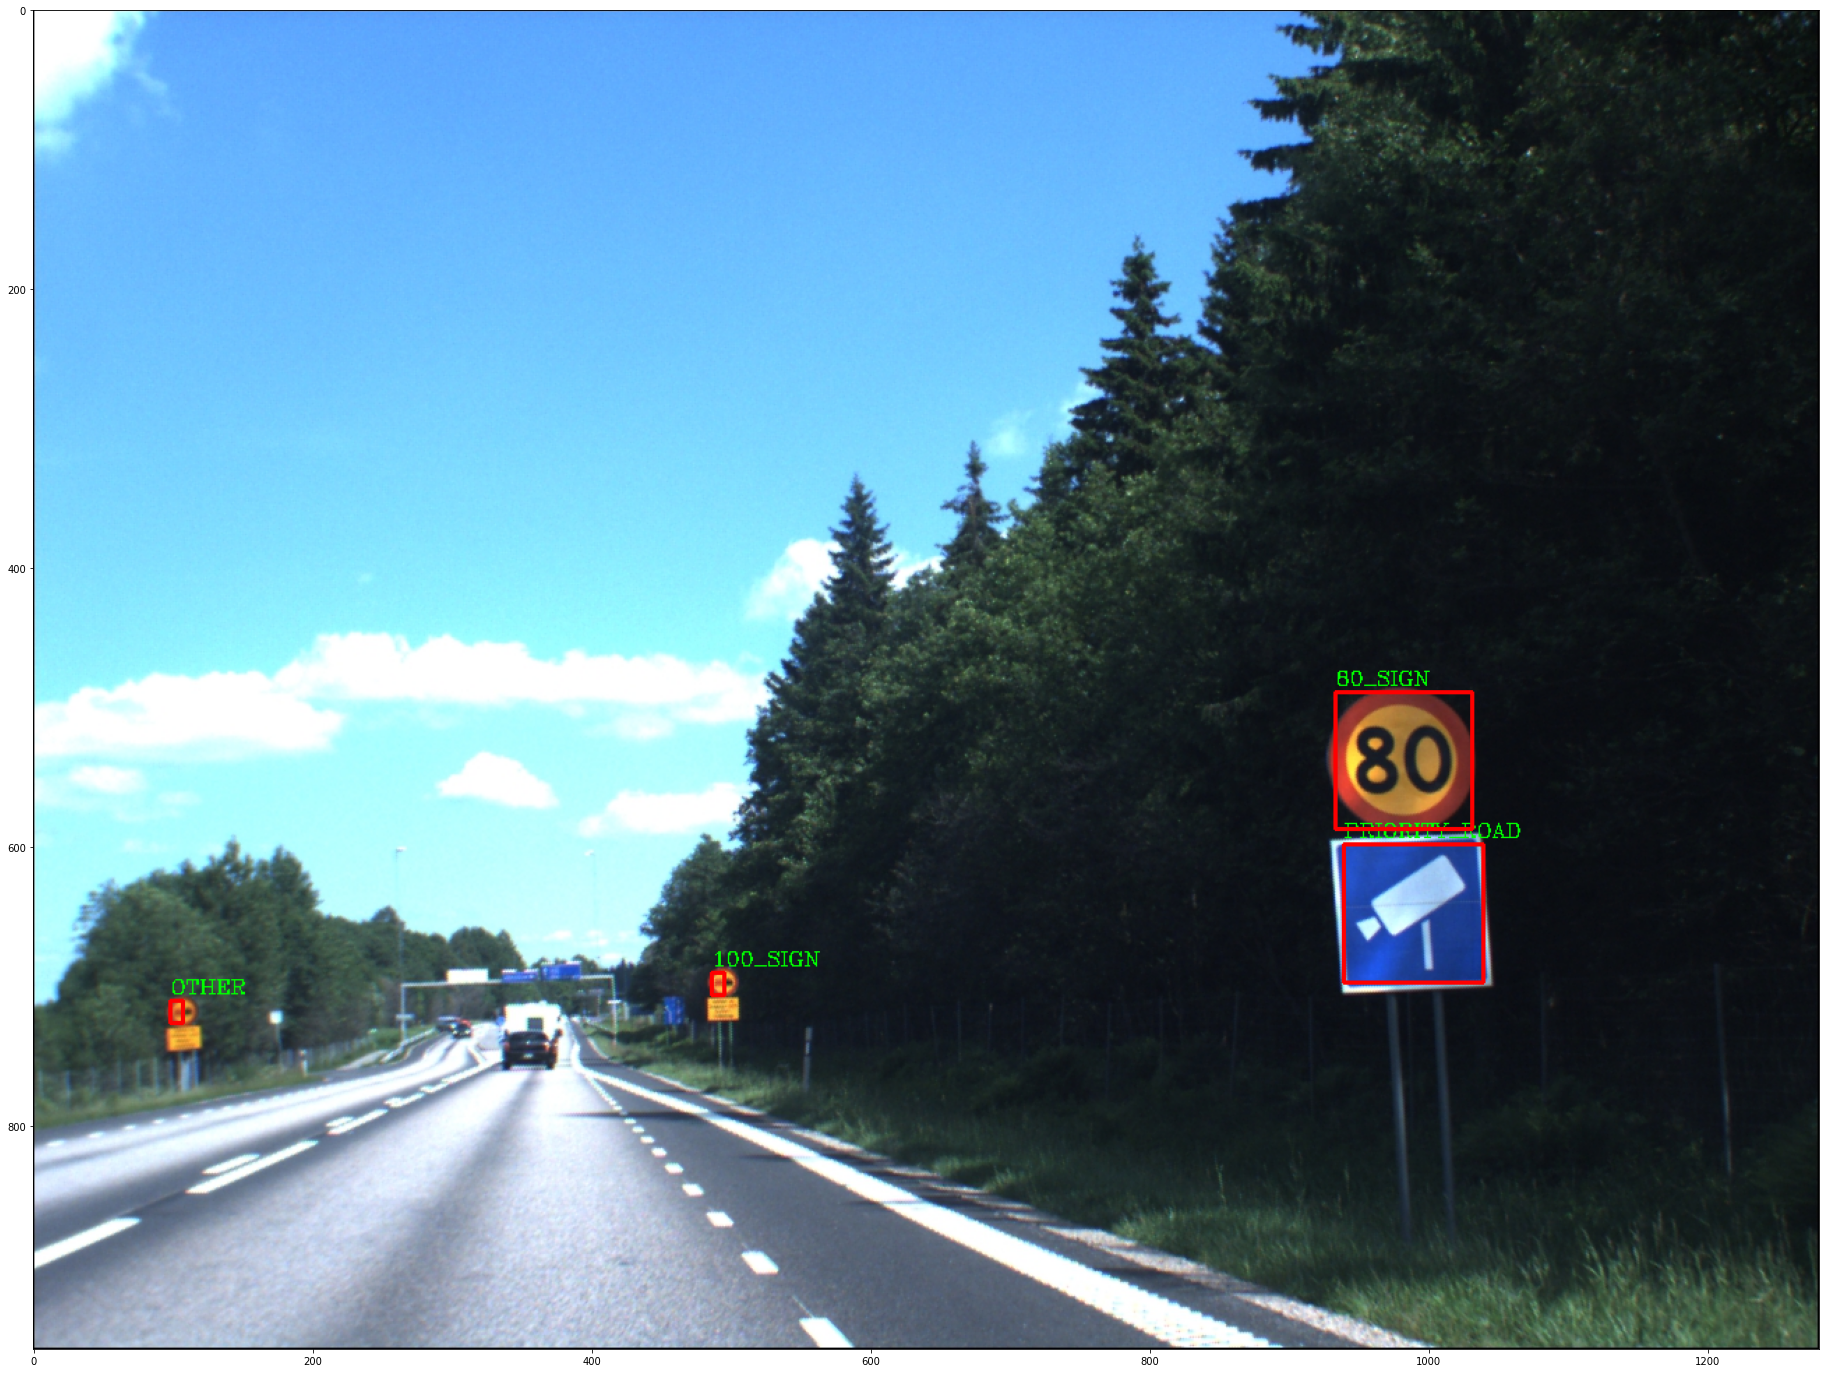

In [69]:
images = {}

for image_file in images_files:
    images[image_file] = (cv2.imread(input_path + "/" + image_file))
    
image_to_test = (images[images_files[0]])
imag = classify_ROI(image_to_test)
plt.figure(figsize=(32, 32))
plt.imshow(imag)